In [115]:
import pandas as pd
import numpy as np

import sympy
from sympy import ordered, Matrix, hessian, Trace
from sympy.vector import laplacian, divergence, gradient, curl, CoordSys3D, Del
from sympy.plotting import plot3d 

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
## Open Tab-seperated file with lsit of X,Y,z positions of data

# filename = "20230405/S600_2p925mmCer_die_attach_deformation.txt"
# filename = "20230405/S600_3p785mmCer_die_attach_deformation.txt"
# filename="20230405/S800_2p925mmCer_die_attach_deformation.txt"
# filename="20230405/S800_3p785mmCer_die_attach_deformation.txt"
# filename="20230405/S800_3p9mmCer_die_attach_deformation.txt"
# filename="20230405/S800_4p0mmCer_die_attach_deformation.txt"
# filename="20230405/S800_4p1mmCer_die_attach_deformation.txt"
filename="20230405/S800_4p2mmCer_die_attach_deformation.txt"

C_NODE = "Node Number"
C_X = "X Location (mm)"
C_Y = "Y Location (mm)"
C_Z = "Z Location (mm)"
C_DEF = "Total Deformation (mm)"

df = pd.read_csv(filename, sep="\t")
cols = df.columns
print(cols)
df

ax = plt.axes(projection='3d')
ax.scatter(df[C_X], df[C_Y], df[C_DEF], c=df[C_DEF], cmap='viridis')

ax.ticklabel_format(style='plain', axis='z', scilimits=(0, 0))
ax.set_title(f'{filename}\ndeformation along die attach')
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.set_zlabel('deformation (mm)')
# ax.view_init(30, -145)

In [ ]:
# Find bounding box of data
x_min = df.iloc[0][C_X]
y_min = df.iloc[0][C_Y]
x_max = df.iloc[0][C_X]
y_max = df.iloc[0][C_Y]
for index, row in df.iterrows():
    # print(row[C_X], row[C_Y])
    x = float(row[C_X])
    y = float(row[C_Y])
    if y > y_max:
        y_max = y
    if x > x_max:
        x_max = x
    if y < y_min:
        y_min = y
    if x < x_min:
        x_min = x

print(f"Range = Min: ({x_min},{y_min})  Max: ({x_max},{y_max})")

resolution = 0.5
x_steps = np.arange(x_min, x_max, resolution)
y_steps = np.arange(y_min, y_max, resolution)
nx = len(x_steps)
ny = len(y_steps)

data = []
for p_x in x_steps:
    for p_y in y_steps:
        df_closest = (
            df.copy(deep=True)
            .assign(d=(p_x - df[C_X]) ** 2 + (p_y - df[C_Y]) ** 2)
            .sort_values("d")
            .drop("d", axis=1)
        )
        # biased average
        # sum_dist = sum([(p_x - df_closest.iloc[i][C_X]) ** 2 + (p_y - df_closest.iloc[i][C_Y]) ** 2 for i in range(0,2)])
        # avg = (
        #     sum([df_closest.iloc[i][C_DEF] * ( (p_x - df_closest.iloc[i][C_X]) ** 2 + (p_y - df_closest.iloc[i][C_Y]) ** 2 )/sum_dist for i in range (0,2)])
        #     # / sum_dist
        # )
        # data.append({C_X: p_x, C_Y: p_y, C_DEF: avg})
        data.append({C_X: p_x, C_Y: p_y, C_DEF: df_closest.iloc[0][C_DEF]})

df_ortho = pd.DataFrame(data)

Z = np.empty((len(y_steps),0))
for x_pos in x_steps:
    col = []
    for y_pos in y_steps:
        df_val = df_ortho.loc[(df_ortho[C_X] == x_pos) & (df_ortho[C_Y] == y_pos)]
        col.append(df_val[C_DEF])
    npcol = np.vstack(col)
    Z = np.append(Z,npcol,1)

print("Note: Matrix forms have flipped y axis (upside-down)")
plt.matshow(Z)


x**2 + y**2


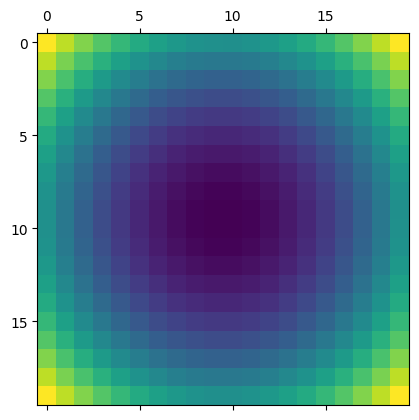

In [136]:
# Generated Gaussian Z test data
# fstr = "0.2+(1/(2*pi*1**2))*exp(-(x**2+y**2)/(2*1**2))"
fstr = "x**2+y**2"
x_min =-5
x_max=5
y_min=-5
y_max=5
resolution = 0.5
x_steps = np.arange(x_min, x_max, resolution)
y_steps = np.arange(y_min, y_max, resolution)
nx = len(x_steps)
ny = len(y_steps)
f = sympy.parsing.sympy_parser.parse_expr(fstr, evaluate=False)
print(f)
v = list(ordered(f.free_symbols)); v

x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)

Z = np.empty(shape=(ny, nx))

for i in range(len(x)):
    for j in range(len(y)):
        Z[j, i] = f.subs({v[0]: x[i], v[1]: y[j]})

np.random.seed(42)
noise_sigma = 0.001
Z += noise_sigma * np.random.randn(*Z.shape)
plt.matshow(Z)

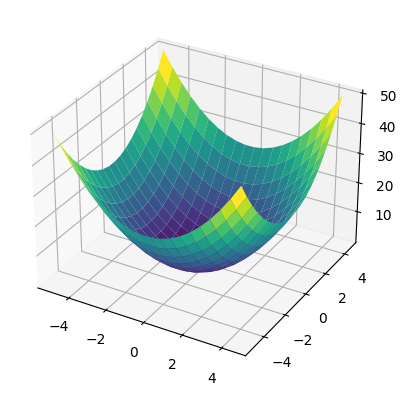

In [137]:
X, Y = np.meshgrid(x_steps, y_steps)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

The polynomial regression model: 1, x, x^2, ..., xy, x^2y, ... etc.

$$
z_i \,=\, c_0 + c_1 x_i + c_2 x_i^2 + \cdots + c_{i} y_{i} + c_{i} x_{i} y_{i} + c_i x_i^2 y_i + \cdots + c_m x_i^m y_i^m + \varepsilon_i\  (i = 1, 2, \dots , n) 
$$

can be expressed in matrix form in terms of a design matrix $\mathbf{A}$, a response vector $\vec y$, a parameter vector $\vec c$, and a vector $\vec\varepsilon$ of random errors. The ''i''-th row of $\mathbf{A}$ and $\vec y$ will contain the ''x'' and ''y'' value for the ''i''-th data sample. Then the model can be written as a system of linear equations:

$$
 \begin{bmatrix} z_1\\ z_2\\ z_3 \\ \vdots \\ z_n \end{bmatrix}= \begin{bmatrix} 1 & x_1 & x_1^2 & \dots & x_1^m y_1^m \\ 1 & x_2 & x_2^2 &  \dots & x_2^m y_2^m \\ 1 & x_3 & x_3^2 & \dots & x_3^m y_3^m \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_n & x_n^2 & \dots & x_n^m y_n^m \end{bmatrix} \begin{bmatrix} c_0\\ c_1\\ c_2\\ \vdots \\ c_{m^2} \end{bmatrix} + \begin{bmatrix} \varepsilon_1\\ \varepsilon_2\\ \varepsilon_3 \\ \vdots \\ \varepsilon_n \end{bmatrix}, 
$$

which when using pure matrix notation is written as

$$
\vec z = \mathbf{A} \vec c + \vec\varepsilon
$$

f(x,y) = 0.1386527486920433 * x**0 * y**0 + 0.5540473335273206 * x**1 * y**0 + 1.1080097671917177 * x**2 * y**0 + -3.590324808375872e-07 * x**3 * y**0 + 9.831816568661722e-07 * x**4 * y**0 + 0.554019790640363 * x**0 * y**1 + -5.520487799119716e-06 * x**1 * y**1 + -1.1693853392332615e-06 * x**2 * y**1 + -3.693116980259606e-07 * x**3 * y**1 + 1.1080303773762783 * x**0 * y**2 + -1.1207373818442404e-06 * x**1 * y**2 + -3.6535881375865387e-07 * x**2 * y**2 + 2.0204266706867757e-06 * x**0 * y**3 + 1.524888517751271e-06 * x**1 * y**3 + 6.1476695289997e-08 * x**0 * y**4
RMS residual = 0.0009418155311296014


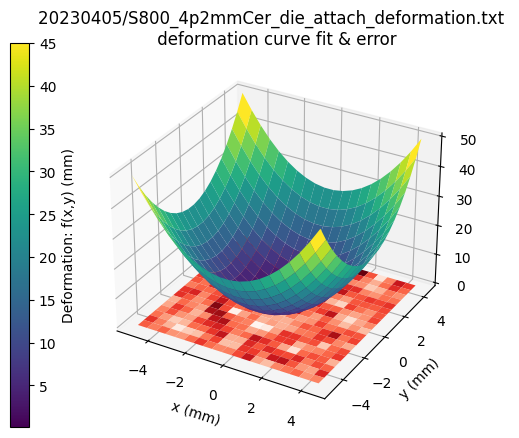

In [138]:
# https://scipython.com/blog/linear-least-squares-fitting-of-a-two-dimensional-data/


def get_basis(x, y, max_order=4):
    """Return the fit basis polynomials: 1, x, x^2, ..., xy, x^2y, ... etc."""
    basis = []
    for i in range(max_order+1):
        for j in range(max_order - i +1):
            basis.append(x**j * y**i)
    return basis

def get_basis_str(x, y, max_order=4):
    """Return the fit basis polynomials: 1, x, x^2, ..., xy, x^2y, ... etc."""
    basis_str = []
    for i in range(max_order+1):
        for j in range(max_order - i +1):
            basis_str.append(f'x**{j} * y**{i}')
    return basis_str

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
x, y = X.ravel(), Y.ravel()
# Maximum order of polynomial term in the basis.
max_order = 4
basis = get_basis(x, y, max_order)
# Linear, least-squares fit.
A = np.vstack(basis).T
b = Z.ravel()

# https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
c, r, rank, s = np.linalg.lstsq(A, b, rcond=None)
# c is our basis coefficients

basis_str = get_basis_str(x, y, max_order)
fstr = ' + '.join([f'{c[i]} * {basis_str[i]}' for i in range(len(c))])
print("f(x,y) =", fstr)

# Calculate the fitted surface from the coefficients, c.
fit = np.sum(c[:, None, None] * np.array(get_basis(X, Y, max_order))
                .reshape(len(basis), *X.shape), axis=0)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.title(f'{filename} \n deformation curve fit & error')
pcm = ax.plot_surface(X, Y, fit, cmap='viridis')
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
# Adding the colorbar
cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8]) 
fig.colorbar(pcm, cax = cbaxes)
plt.ylabel("Deformation: f(x,y) (mm)")
pcm = ax.plot_surface(X, Y, Z-fit, cmap='Reds')
# Add Labels

In [121]:
## 2D Gaussian Distribution Test
fstr = "(1/(2*pi*1**2))*exp(-(x**2+y**2)/(2*1**2))"
x_min =-3
x_max=3
y_min=-3
y_max=3
resolution = 0.3
x_steps = np.arange(x_min, x_max, resolution)
y_steps = np.arange(y_min, y_max, resolution)
nx = len(x_steps)
ny = len(y_steps)

In [122]:
f = sympy.parsing.sympy_parser.parse_expr(fstr, evaluate=False)
f

1*exp((-x**2 - y**2)/((2*1**2)))/(2*pi*1**2)

In [123]:
# get our variables
v = list(ordered(f.free_symbols)); v

[x, y]

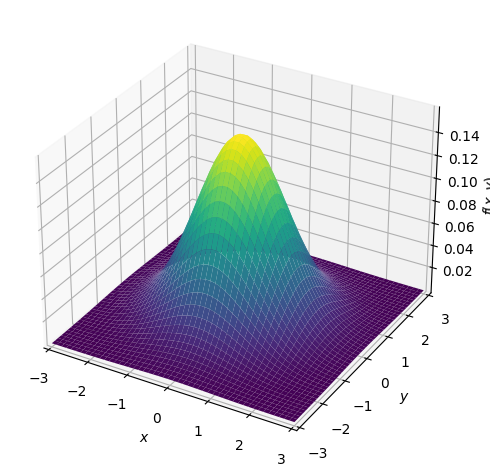

In [124]:
pcm = plot3d(f, (v[0], x_min, x_max), (v[1], y_min, y_max))

In [125]:
gradient = lambda f, v: Matrix([f]).jacobian(v)
g = gradient(f, v)
g

Matrix([[-1/(2*pi)*x*exp((-x**2 - y**2)/((2*1**2))), -1/(2*pi)*y*exp((-x**2 - y**2)/((2*1**2)))]])

In [126]:
h = hessian(f, v)
h

Matrix([
[x**2*exp((-x**2 - y**2)/((2*1**2)))/(2*pi) - exp((-x**2 - y**2)/((2*1**2)))/(2*pi),                                          x*y*exp((-x**2 - y**2)/((2*1**2)))/(2*pi)],
[                                         x*y*exp((-x**2 - y**2)/((2*1**2)))/(2*pi), y**2*exp((-x**2 - y**2)/((2*1**2)))/(2*pi) - exp((-x**2 - y**2)/((2*1**2)))/(2*pi)]])

In [127]:
# laplacian
# l = divergence(gradient(f,v), v)
# l = f.diff(v[0]).diff(v[0]) + f.diff(v[1]).diff(v[1])
# l = Trace(h)
l = h.trace()
l

x**2*exp((-x**2 - y**2)/((2*1**2)))/(2*pi) + y**2*exp((-x**2 - y**2)/((2*1**2)))/(2*pi) - exp((-x**2 - y**2)/((2*1**2)))/pi

For a surface described as graph of a function $z = F(x, y)$, Gaussian curvature is:

$$
K = \frac{F_{xx}\cdot F_{yy}- F_{xy}^2}{\left(1+F_x^2+ F_y^2\right)^2}
$$

For the special case of a surface defined as a function of two coordinates, e.g. $z = S(x, y)$, and using the upward pointing normal the mean curvature expression is


$$
H = \frac{1}{2}
\frac{
\left(1 + \left(\frac{\partial S}{\partial x}\right)^2\right) \frac{\partial^2 S}{\partial y^2} - 
2 \frac{\partial S}{\partial x} \frac{\partial S}{\partial y} \frac{\partial^2 S}{\partial x \partial y} + 
\left(1 + \left(\frac{\partial S}{\partial y}\right)^2\right) \frac{\partial^2 S}{\partial x^2}
}{\left(1 + \left(\frac{\partial S}{\partial x}\right)^2 + \left(\frac{\partial S}{\partial y}\right)^2\right)^{3/2}}
$$

In [128]:
def mean_curvature_2d(f, v):
    """
    f is a sympy expression
    The Gaussian curvature is the product of the two principal curvatures, so it is 1/mm^2.
    """
    # https://en.wikipedia.org/wiki/Mean_curvature
    f_x, f_y = gradient(f, v)
    f_xx, f_xy = gradient(f_x, v)
    f_yx, f_yy = gradient(f_y, v)
    H = (((1 + f_x**2)*f_yy - 2*f_x*f_y*f_xy + (1 + f_y**2)*f_xx) / ((1 + f_x**2 + f_y**2)**(3/2)))/2
    return H

def gaussian_curvature_2d(f, v):
    """
    f is a sympy expression
    """
    # https://en.wikipedia.org/wiki/Gaussian_curvature
    f_x, f_y = gradient(f, v)
    f_xx, f_xy = gradient(f_x, v)
    f_yx, f_yy = gradient(f_y, v)
    K = (f_xx*f_yy-f_xy**2)/((1+f_x**2+f_y**2)**2)
    return K

def mean_curvature_2d_finite(Z):
    """
    X is a 2D array, Y is a 2D array, and Z is a 2D array. If you have an unstructured cloudpoint, with a single matrix shaped Nx3 (the first column being X, the second being Y and the third being Z) then you can't apply this matlab function.
    This assumes that your data points are 1 unit apart.
    """
    # https://stackoverflow.com/questions/11317579/surface-curvature-matlab-equivalent-in-python
    Zy, Zx  = np.gradient(Z)
    Zxy, Zxx = np.gradient(Zx)
    Zyy, _ = np.gradient(Zy)

    H = (Zx**2 + 1)*Zyy - 2*Zx*Zy*Zxy + (Zy**2 + 1)*Zxx
    H = H/(2*(Zx**2 + Zy**2 + 1)**(1.5))

    return H

def gaussian_curvature_2d_finite(Z):
    """
    Z is a 2D array
    The curvature in general is measured as 1/r, where r is the radius of an inscribed circle. Since mean curvature is the average of the two principal curvatures it has the units of 1/mm. The Gaussian curvature is the product of them, so it is 1/mm^2.
    """
    # https://stackoverflow.com/questions/11317579/surface-curvature-matlab-equivalent-in-python
    Zy, Zx = np.gradient(Z)                                                     
    Zxy, Zxx = np.gradient(Zx)                                                  
    Zyy, _ = np.gradient(Zy)                                                    
    K = (Zxx * Zyy - (Zxy ** 2)) /  (1 + (Zx ** 2) + (Zy **2)) ** 2             
    return K

def surfature(X,Y,Z):
    # https://github.com/sujithTSR/surface-curvature/blob/master/surface.py
    # where X, Y, Z matrices have a shape (lr+1,lb+1)

    (lr,lb)=X.shape

    #First Derivatives
    Xv,Xu=np.gradient(X)
    Yv,Yu=np.gradient(Y)
    Zv,Zu=np.gradient(Z)

    #Second Derivatives
    Xuv,Xuu=np.gradient(Xu)
    Yuv,Yuu=np.gradient(Yu)
    Zuv,Zuu=np.gradient(Zu)   

    Xvv,Xuv=np.gradient(Xv)
    Yvv,Yuv=np.gradient(Yv)
    Zvv,Zuv=np.gradient(Zv) 

    #Reshape to 1D vectors
    Xu=np.reshape(Xu,lr*lb)
    Yu=np.reshape(Yu,lr*lb)
    Zu=np.reshape(Zu,lr*lb)
    Xv=np.reshape(Xv,lr*lb)
    Yv=np.reshape(Yv,lr*lb)
    Zv=np.reshape(Zv,lr*lb)
    Xuu=np.reshape(Xuu,lr*lb)
    Yuu=np.reshape(Yuu,lr*lb)
    Zuu=np.reshape(Zuu,lr*lb)
    Xuv=np.reshape(Xuv,lr*lb)
    Yuv=np.reshape(Yuv,lr*lb)
    Zuv=np.reshape(Zuv,lr*lb)
    Xvv=np.reshape(Xvv,lr*lb)
    Yvv=np.reshape(Yvv,lr*lb)
    Zvv=np.reshape(Zvv,lr*lb)

    Xu=np.c_[Xu, Yu, Zu]
    Xv=np.c_[Xv, Yv, Zv]
    Xuu=np.c_[Xuu, Yuu, Zuu]
    Xuv=np.c_[Xuv, Yuv, Zuv]
    Xvv=np.c_[Xvv, Yvv, Zvv]

    #% First fundamental Coeffecients of the surface (E,F,G)
    E=np.einsum('ij,ij->i', Xu, Xu) 
    F=np.einsum('ij,ij->i', Xu, Xv) 
    G=np.einsum('ij,ij->i', Xv, Xv) 

    m=np.cross(Xu,Xv,axisa=1, axisb=1)
    p=np.sqrt(np.einsum('ij,ij->i', m, m))
    n=m/np.c_[p,p,p]

    #% Second fundamental Coeffecients of the surface (L,M,N)
    L= np.einsum('ij,ij->i', Xuu, n) 
    M= np.einsum('ij,ij->i', Xuv, n) 
    N= np.einsum('ij,ij->i', Xvv, n) 

    #% Gaussian Curvature
    K=(L*N-M**2)/(E*G-F**2)
    K=np.reshape(K,lr*lb)

    # return K

    #% Mean Curvature
    H = (E*N + G*L - 2*F*M)/(2*(E*G - F**2))
    # H = np.reshape(H,lr*lb)
    H = np.reshape(H,(lr,lb))

    # return H

    # #% Principle Curvatures
    Pmax = H + np.sqrt(H**2 - K)
    Pmin = H - np.sqrt(H**2 - K)

    return Pmax,Pmin

https://math.stackexchange.com/questions/1985889/why-how-does-the-determinant-of-the-hessian-matrix-combined-with-the-2nd-deriva 

https://machinelearningmastery.com/a-gentle-introduction-to-the-laplacian/

https://mathworld.wolfram.com/MeanCurvature.html



In [129]:
H = mean_curvature_2d(f, v)
H

(-x**2*y**2*exp((-x**2 - y**2)/((2*1**2)))*exp(-x**2 - y**2)/(4*pi**3) + (x**2*exp(-x**2 - y**2)/(4*pi**2) + 1)*(y**2*exp((-x**2 - y**2)/((2*1**2)))/(2*pi) - exp((-x**2 - y**2)/((2*1**2)))/(2*pi)) + (y**2*exp(-x**2 - y**2)/(4*pi**2) + 1)*(x**2*exp((-x**2 - y**2)/((2*1**2)))/(2*pi) - exp((-x**2 - y**2)/((2*1**2)))/(2*pi)))/(2*(x**2*exp(-x**2 - y**2)/(4*pi**2) + y**2*exp(-x**2 - y**2)/(4*pi**2) + 1)**1.5)

In [130]:
K = gaussian_curvature_2d(f,v)
K

(-x**2*y**2*exp(-x**2 - y**2)/(4*pi**2) + (x**2*exp((-x**2 - y**2)/((2*1**2)))/(2*pi) - exp((-x**2 - y**2)/((2*1**2)))/(2*pi))*(y**2*exp((-x**2 - y**2)/((2*1**2)))/(2*pi) - exp((-x**2 - y**2)/((2*1**2)))/(2*pi)))/(x**2*exp(-x**2 - y**2)/(4*pi**2) + y**2*exp(-x**2 - y**2)/(4*pi**2) + 1)**2

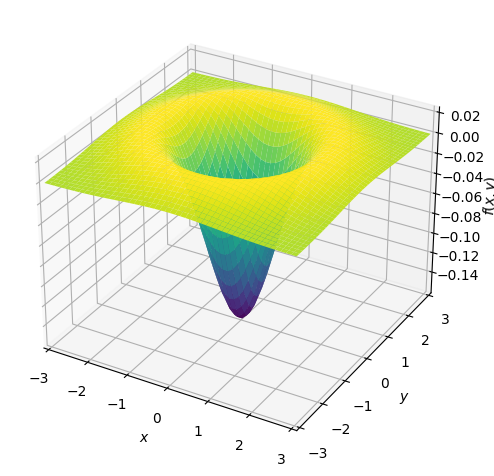

In [131]:
plot3d(H, (v[0], x_min, x_max), (v[1], y_min, y_max))

Discretize the function (Convert to 2D Vector) so we can easily find max and min

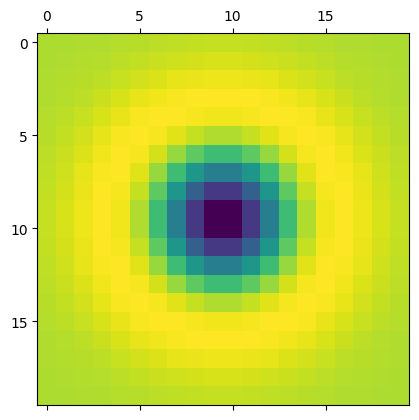

In [132]:
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)

a = np.empty(shape=(ny, nx))

# Implicit 2D mean curvature
H = mean_curvature_2d(f, v)
for i in range(len(x)):
    for j in range(len(y)):
        a[j, i] = H.subs({v[0]: x[i], v[1]: y[j]})
        # a[j, i] = K.subs({v[0]: x[i], v[1]: y[j]})

# Finite mean curvature
# for i in range(len(x)):
#     for j in range(len(y)):
#         a[j, i] = f.subs({v[0]: x[i], v[1]: y[j]})
# plt.matshow(a)

# a = mean_curvature_2d_finite(a)
# a = gaussian_curvature_2d_finite(a)

# X, Y = np.meshgrid(x, y)
# a = surfature(X,Y,a)

plt.matshow(a)

In [133]:
max_i,max_j = np.unravel_index(a.argmax(), a.shape)
min_i,min_j = np.unravel_index(a.argmin(), a.shape)

print(f'{filename} mean curvature')
print(f'Min: {a.min()} rc:{min_i,min_j} xy:{min_j*resolution,min_i*resolution}  Max: {a.max()} rc:{max_i,max_j} xy:{max_j*resolution,max_i*resolution}  Mean: {a.mean()}')
print(f"Absolute Maximum mean curvature: {np.max([np.abs(a.min()), abs(a.max())])}")

20230405/S800_4p2mmCer_die_attach_deformation.txt mean curvature
Min: -0.1511866792835399 rc:(9, 9) xy:(2.6999999999999997, 2.6999999999999997)  Max: 0.02145819961095095 rc:(5, 5) xy:(1.5, 1.5)  Mean: -0.00041848303005921877
Absolute Maximum mean curvature: 0.1511866792835399


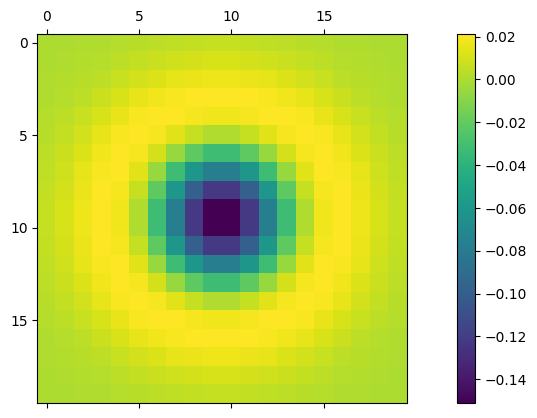

In [134]:
# plt.matshow(a) # , vmin=-9, vmax=9

fig = plt.figure()
ax = fig.add_subplot(111)
pcm = ax.matshow(a) 
# Adding the colorbar
fig.colorbar(pcm, pad=0.1)

Text(0, 0.5, 'Mean Curvature: H(x,y)')

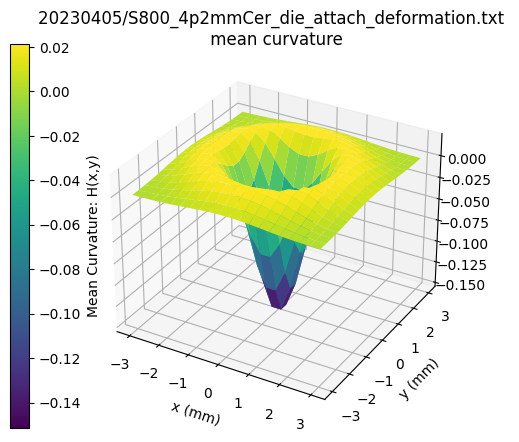

In [135]:
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.title(f'{filename} \n mean curvature')
asm = ax.plot_surface(X, Y, a, cmap='viridis')
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8]) 
fig.colorbar(pcm, cax = cbaxes)
plt.ylabel("Mean Curvature: H(x,y)")
# ax.view_init(30, -125)